In [6]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
r"""

Gravimetry in 2D - Part I
-------------------------

Simple gravimetric field solution.

"""

import numpy as np
import pygimli as pg
from pygimli.meshtools import createCircle, createWorld, createMesh
from pygimli.physics.gravimetry import gradUCylinderHoriz, solveGravimetry


# True values
radius_init = 2.  # [m]
depth_init = 5.  # [m]
pos_init = [5., -depth_init]
dRho_init = 100


x = np.arange(-20, 20.1, .5)
pnts = np.array([x, np.zeros(len(x))]).T


# Analytical solution
gz_a = gradUCylinderHoriz(pnts, radius_init, dRho_init, pos_init)[:, 1]

In [7]:
# Density
dRho = 100

# RMSE Threshold
RMSE_threshold = 0.0002

In [12]:
# Random normal distriution - radius, depth and pos
random_radius = np.random.normal(2,3,50)
random_depth = np.random.normal(5,5,50)
random_pos = np.random.normal(0,10,50)

In [13]:
# Function that finds the best arguments for our model based on RMSE values
def solution(random_radius, random_depth, random_pos, RMSE_threshold):
    for radius in random_radius:
        for depth in random_depth:
            for pos in random_pos:
                if radius > 0 and radius < depth and depth > 0 and depth < 10:
                    pos_value = [pos, -depth]
                    
                    circ = createCircle(pos_value, radius=radius, marker=2, area=0.1, nSegments=16)
                    gz_p = solveGravimetry(circ, dRho, pnts, complete=False)
                    
                    RMSE_value = np.sqrt(np.square(np.subtract(gz_a,gz_p)).mean())
                    if RMSE_value < RMSE_threshold:
                        return {"radius":radius, "depth":depth, "pos":pos_value, "RMSE":RMSE_value}
    return -1

In [14]:
# Result
res = solution(random_radius,random_depth,random_pos, RMSE_threshold)
res

{'radius': 2.192747590056182,
 'depth': 5.514440849134137,
 'pos': [4.630863386380095, -5.514440849134137],
 'RMSE': 0.00019937040253988222}

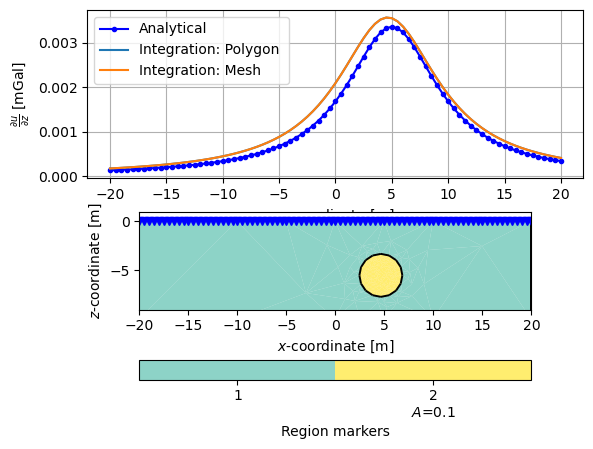

In [15]:
# Integration for a 2D polygon after :cite:`WonBev1987`
circ = createCircle(res["pos"], radius=res["radius"], marker=2, area=0.1, nSegments=16)
gz_p = solveGravimetry(circ, dRho, pnts, complete=False)

# Integration for complete 2D mesh after :cite:`WonBev1987`
world = createWorld(start=[-20, 0], end=[20, -10], marker=1)
mesh = createMesh([world, circ])
dRhoC = pg.solver.parseMapToCellArray([[1, 0.0], [2, dRho]], mesh)
gc_m = solveGravimetry(mesh, dRhoC, pnts)

plc = world + circ

# Finishing the plots
ax1 = pg.plt.subplot(2, 1, 1)
ax1.plot(x, gz_a, '-b', marker='.', label='Analytical')
ax1.plot(x, gz_p, label='Integration: Polygon ')
ax1.plot(x, gc_m, label='Integration: Mesh')

ax2 = pg.plt.subplot(2, 1, 2)
pg.show(plc, ax=ax2)
ax2.plot(x, x*0,  'bv')

ax1.set_ylabel(r'$\frac{\partial u}{\partial z}$ [mGal]')
ax1.set_xlabel('$x$-coordinate [m]')
ax1.grid()
ax1.legend()

ax2.set_aspect(1)
ax2.set_xlabel('$x$-coordinate [m]')
ax2.set_ylabel('$z$-coordinate [m]')
ax2.set_ylim((-9, 1))
ax2.set_xlim((-20, 20))

pg.wait()